In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import glob
import seaborn as sns
import matplotlib.image as mpimg
import os
import scipy
import gc

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
def loadImages(path):
    # Put files into lists and return them as one list of size 4
    image_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if      file.endswith('.tif')])
 
    return image_files

In [3]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()# Preprocessing
def processing(data):
    # loading image
    # Getting all images to work with 
    img = [cv2.imread(i, cv2.IMREAD_COLOR) for i in data]    
    print('Original size',img[0].shape)
    # --------------------------------
    # setting dim of the resize
    height = 128
    width = 128
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_CUBIC)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[1].shape)
    print("RESIZED type", res_img[1].dtype)
    
    # Visualizing one of the images in the array
    original = res_img[1]
    display_one(original)
    # ----------------------------------
    # Remove noise
    # Gaussian
    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)


    image = no_noise[1]
    m = len(no_noise)
    display(original, image, 'Original', 'Blured')
    Y = np.zeros((1,m))
    count = 0
    for img in range(len(no_noise)):
        if img < 1100:
            Y[0, img] = 0
        elif img > 1100 and img < 2200:
            Y[0, img] = 1
        elif img > 2200 and img < 3300:
            Y[0, img] = 2
        else:
            Y[0, img] = 3
            
    
    
    return no_noise, Y
    #---------------------------------
    

In [4]:
from sklearn.model_selection import train_test_split

# defining global variable path
dirname = os.path.abspath('')
print(dirname)
image_path = os.path.join(dirname, 'dataset/dataset')
print(image_path)
classes = ["broadleaf","grass","soil","soybean"]
    
broadleaf = loadImages(os.path.join(image_path,"broadleaf"))
   
grass = loadImages(os.path.join(image_path,"grass"))
    
soil = loadImages(os.path.join(image_path,"soil"))
    
soybean = loadImages(os.path.join(image_path,"soybean"))
    
images = np.concatenate((broadleaf, grass, soil, soybean), axis=0)
    
print("List of files the first 3 in the folder:\n",broadleaf[:3])
print("--------------------------------")
del broadleaf
del grass
del soil
del soybean
gc.collect()

/home/toni/Desktop/ML/Week7/PlantDiseaseDetection
/home/toni/Desktop/ML/Week7/PlantDiseaseDetection/dataset/dataset
List of files the first 3 in the folder:
 ['/home/toni/Desktop/ML/Week7/PlantDiseaseDetection/dataset/dataset/broadleaf/1.tif', '/home/toni/Desktop/ML/Week7/PlantDiseaseDetection/dataset/dataset/broadleaf/10.tif', '/home/toni/Desktop/ML/Week7/PlantDiseaseDetection/dataset/dataset/broadleaf/100.tif']
--------------------------------


11

Original size (187, 201, 3)
RESIZED (128, 128, 3)
RESIZED type uint8


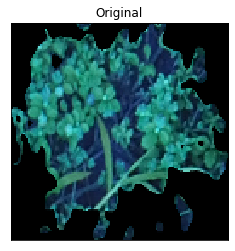

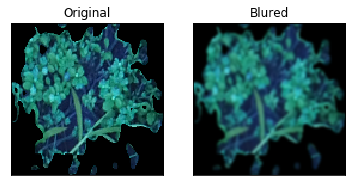

Checking if lengths are consistent
216268800
(4400, 128, 128, 3)
4400
(1, 4400)
--------------------------------


In [5]:
# sending all the images to pre-processing
X, Y = processing(images)
X = np.array(X)
    
del images
gc.collect()
    
print("Checking if lengths are consistent")
print(X.size)
print(X.shape)
print(Y.size)
print(Y.shape)
print("--------------------------------")

In [6]:
ROWS = 128
COLS = 128
CHANNELS = 3
X_train, X_test, y_train, y_test = train_test_split(X,Y[0],test_size=0.18, random_state=43)

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

del X
del Y
gc.collect()

# train_set_x_flatten = X_train.reshape(X_train.shape[0], ROWS*COLS*CHANNELS).T
# test_set_x_flatten = X_test.reshape(X_test.shape[0], -1).T

# del X_train
# del X_test
# gc.collect()

# train_set_x = train_set_x_flatten/255
# test_set_x = test_set_x_flatten/255

# del train_set_x_flatten
# del test_set_x_flatten
# gc.collect()

Using TensorFlow backend.
/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framewo

31

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
model = Sequential()#add model layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(4, activation="softmax"))

In [8]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [9]:
#train the model
trained_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12)


Train on 3608 samples, validate on 792 samples
Epoch 1/12
3608/3608 [==============================] - 28s 8ms/step - loss: 2.4279 - accuracy: 0.4268 - val_loss: 0.8597 - val_accuracy: 0.5947
Epoch 2/12
3608/3608 [==============================] - 29s 8ms/step - loss: 0.7980 - accuracy: 0.6200 - val_loss: 0.6843 - val_accuracy: 0.6957
Epoch 3/12
3608/3608 [==============================] - 29s 8ms/step - loss: 0.6164 - accuracy: 0.7239 - val_loss: 0.6217 - val_accuracy: 0.7323
Epoch 4/12
3608/3608 [==============================] - 29s 8ms/step - loss: 0.5664 - accuracy: 0.7605 - val_loss: 0.6018 - val_accuracy: 0.7614
Epoch 5/12
3608/3608 [==============================] - 29s 8ms/step - loss: 0.5131 - accuracy: 0.7844 - val_loss: 0.6148 - val_accuracy: 0.7513
Epoch 6/12
3608/3608 [==============================] - 29s 8ms/step - loss: 0.4787 - accuracy: 0.8027 - val_loss: 0.6033 - val_accuracy: 0.7727
Epoch 7/12
3608/3608 [==============================] - 29s 8ms/step - loss: 0.457

In [10]:
# preds = model.predict(X_test[:790])
actual = y_test[:790]

test_eval = model.evaluate(X_test[:790], actual, verbose=1)

790/790 [==============================] - 1s 2ms/step


In [11]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6184936028492601
Test accuracy: 0.798734188079834


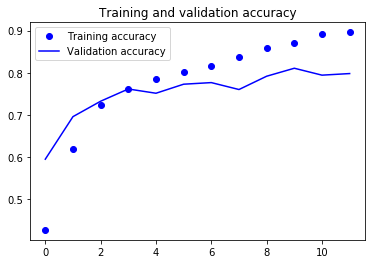

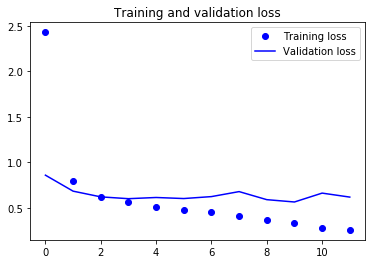

In [13]:
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# On this iteration it got 50% out of 4... Not statistically relevant
# But i may try it again on much more data in the near future
# pred_vals = []
# act_vals = []
# for x in range(len(preds)):
#     max_val_x = max(preds[x])
#     idx_x = list(preds[x]).index(max_val_x)
#     max_val_y = max(actual[x])
#     idx_y = list(actual[x]).index(max_val_y)
#     pred_vals.append(idx_x)
#     act_vals.append(idx_y)
    
    
# print(confusion_matrix(actual, preds))
# print(classification_report(actual, preds))


In [ ]:
# import pandas as pd
# x, y = pd.Series(pred_vals, name="Predicted"), pd.Series(act_vals, name="Actual")
# sns.regplot(x=x, y=y, marker="+")

In [ ]:
# df = pd.DataFrame(columns=classes)

# print(df)

# # sns.ksdeplot(preds, color=['b', 'r', 'g', 'y'])
# # sns.distplot(actual,  color=['b', 'r', 'g', 'y'])